In [1]:
folder_name = '/home/yoyo/Desktop/SimCLR/runs/lp_Jun29_16-34-58_yoyo'

In [2]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report
import importlib.util
import glob
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [4]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/yoyo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 64,
 'epochs': 150,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'None',
 'log_every_n_steps': 50,
 'weight_decay': '10e-6',
 'fp16_precision': False,
 'model': {'out_dim': 64, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(80,240,3)',
  'num_workers': 0,
  'valid_size': 0.1},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [5]:
checkpoints_folder

'/home/yoyo/Desktop/SimCLR/runs/lp_Jun29_16-34-58_yoyo/checkpoints'

In [6]:
def _load_lp(prefix="train"):
    img_list = glob.glob('../data/licenseplate/' + prefix + '/**/*')
    np.random.shuffle(img_list)
    X_train = []
    for f in img_list:
        img = Image.open(f)
        X_train.append(img)
    X_train = np.stack(X_train).transpose(0,3,1,2)
    y_train = np.array([f.split('/')[-2] == 'lp' for f in img_list])
    
    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train

In [7]:
# load facemask train data
X_train, y_train = _load_lp("train")

train images
(152, 3, 80, 240)
(152,)


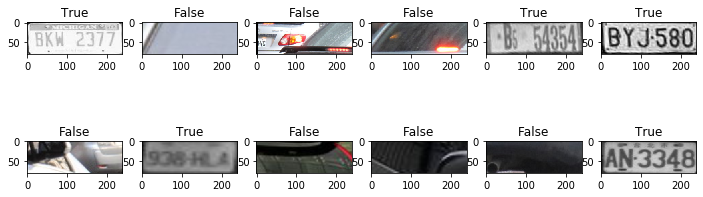

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
    ax.imshow(X_train[i].transpose(1,2,0))
    ax.title.set_text(y_train[i])
plt.show()

In [9]:
# load facemask test data
X_test, y_test = _load_lp("unlabeled")

unlabeled images
(893, 3, 80, 240)
(893,)


## Protocol #2 Logisitc Regression

In [10]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, '../../../models/resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [11]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [12]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [13]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(152, 512)


In [14]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(893, 512)


In [15]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    clf_pred = clf.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, clf_pred, target_names=['no_lp', 'lp'], digits=3))
    
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))
    neigh_pred = neigh.predict(X_test)
    # show a nicely formatted classification report
    print(classification_report(y_test, neigh_pred, target_names=['no_lp', 'lp'], digits=3))
    return clf_pred

In [16]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

clf_pred = linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 1.0
Test score: 0.9697648376259799
              precision    recall  f1-score   support

       no_lp      0.978     0.980     0.979       649
          lp      0.947     0.943     0.945       244

    accuracy                          0.970       893
   macro avg      0.962     0.961     0.962       893
weighted avg      0.970     0.970     0.970       893

-------------------------------
KNN feature eval
Train score: 0.9407894736842105
Test score: 0.9451287793952967
              precision    recall  f1-score   support

       no_lp      0.984     0.940     0.961       649
          lp      0.857     0.959     0.905       244

    accuracy                          0.945       893
   macro avg      0.921     0.949     0.933       893
weighted avg      0.949     0.945     0.946       893



In [23]:
output_dir = '../data/licenseplate/predict/'
if not os.path.exists(output_dir + '/lp/'):
    os.makedirs(output_dir + '/lp/')
else:
    sys.stderr.write('folder exists, delete it first\n')
if not os.path.exists(output_dir + '/nolp/'):
    os.makedirs(output_dir + '/nolp/')
else:
    sys.stderr.write('folder exists, delete it first\n')

folder exists, delete it first
folder exists, delete it first


In [20]:
for i in range(len(clf_pred)):
    if clf_pred[i] == 1:
        fn = f'{output_dir}/lp/{i:04d}.png' 
    else:
        fn = f'{output_dir}/nolp/{i:04d}.png'
    # print(fn)
    im = Image.fromarray(np.uint8(X_test[i].transpose(1,2,0)))
    with open(fn, 'w') as f:
        im.save(fn) 
print('Done', len(clf_pred))

Done 893
